### Binary Notebook

We start with the same 4 classes from the original notebook but convery the Tumor classes into 1 class, so now we only have Tumor vs Non Tumor

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import shutil
import imghdr
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [261]:
IMAGE_SIZE = (256,256,3)
OPT = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)
BATCH_SIZE = 32
NUM_EPOCHS = 40

In [262]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [263]:
training_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Training'
testing_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Testing'

In [ ]:
!nvidia-smi

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [267]:
# Load the training dataset
Training_data = tf.keras.utils.image_dataset_from_directory(
# Training_data = ge.flow_from_directory(
    training_path,
    labels='inferred',
    image_size=(256, 256)
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=42
)

# Load the validation dataset
Validation_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=42
)

# Load the testing dataset
Testing_data = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
)

Found 2910 files belonging to 4 classes.
Using 2328 files for training.
Found 2910 files belonging to 4 classes.
Using 582 files for validation.
Found 394 files belonging to 4 classes.


In [270]:
Training_iterator = Training_data.as_numpy_iterator()
Testing_iterator = Testing_data.as_numpy_iterator()
batch_training = Training_iterator.next()
batch_training[1]

array([1, 0, 3, 0, 0, 3, 1, 3, 3, 1, 0, 3, 2, 0, 1, 3, 0, 0, 3, 1, 3, 2,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 3], dtype=int32)

In [271]:
class_names = Training_data.class_names
print("Class Names:", class_names)

Class Names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


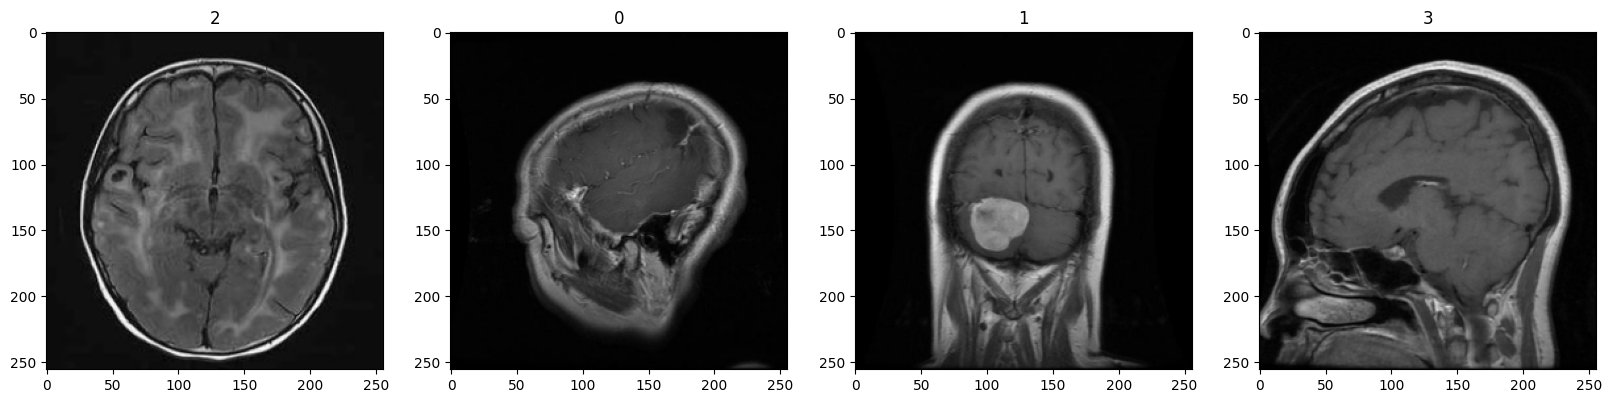

In [272]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index].astype(int))
    ax[idx].title.set_text(batch_training[1][img_index])


In [273]:
# We are now dealing with just 2 lables, 0, 1, and 3 are tumor vs 2 which is non tumor

def augment_image(x, y):

    # Random left-right flip
    x = tf.image.random_flip_left_right(x)
    # Random up-down flip
    x = tf.image.random_flip_up_down(x)
    # Random rotation (90-degree increments)
    num_rotations = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    x = tf.image.rot90(x, k=num_rotations)
    # Random zoom (zooming in or out)
    zoom_factor = tf.random.uniform(shape=[], minval=1, maxval=1.2)
    new_size = tf.cast([256, 256], dtype=tf.float32) * zoom_factor
    x = tf.image.resize(x, tf.cast(new_size, dtype=tf.int32))
    x = tf.image.central_crop(x, central_fraction=0.9)

    # Resize the image to the full grid size
    x = tf.image.resize(x, (256, 256))
    return x, y

def get_positions(x, y): # Gets the position of the 1 so we can identify the type of tumor and then create the label
    positions = tf.where(tf.equal(y, 1))
    positions = tf.gather(positions[:, 1], tf.where(y == 1)[:, 0])
    return x, positions

def map_labels(x, y):
    binary_labels = tf.where(tf.equal(y, 2), 0, 1)  # No tumor (2) becomes 0, others become 1
    return x, binary_labels

def load_and_preprocess_image(file_path, label):
    file_path = training_path
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)  # Assuming your images are JPEG and single-channel
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.uint8)  # Ensure the dtype is uint8
    return img



In [274]:
tf.config.run_functions_eagerly(True)

num_classes = 4  # Adjust based on your number of classes

# Load the training dataset
Training_data = Training_data.map(augment_image)
Training_data = Training_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))
Training_data = Training_data.map(get_positions)
Training_data = Training_data.map(map_labels)


# Load the validation dataset
Validation_data = Validation_data.map(augment_image)
Validation_data = Validation_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))
Validation_data = Validation_data.map(get_positions)
Validation_data = Validation_data.map(map_labels)

# Load the testing dataset
Testing_data = Testing_data.map(augment_image)
Testing_data = Testing_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))
Testing_data = Testing_data.map(get_positions)
Testing_data = Testing_data.map(map_labels)

# X is Images
# Y is Labels

In [275]:
batch_training = Training_data.as_numpy_iterator().next()

In [276]:
batch_training[1] # We can see the labels are now all 0 and 1 to represent Tumor vs Non Tumor, which is what we wanted

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

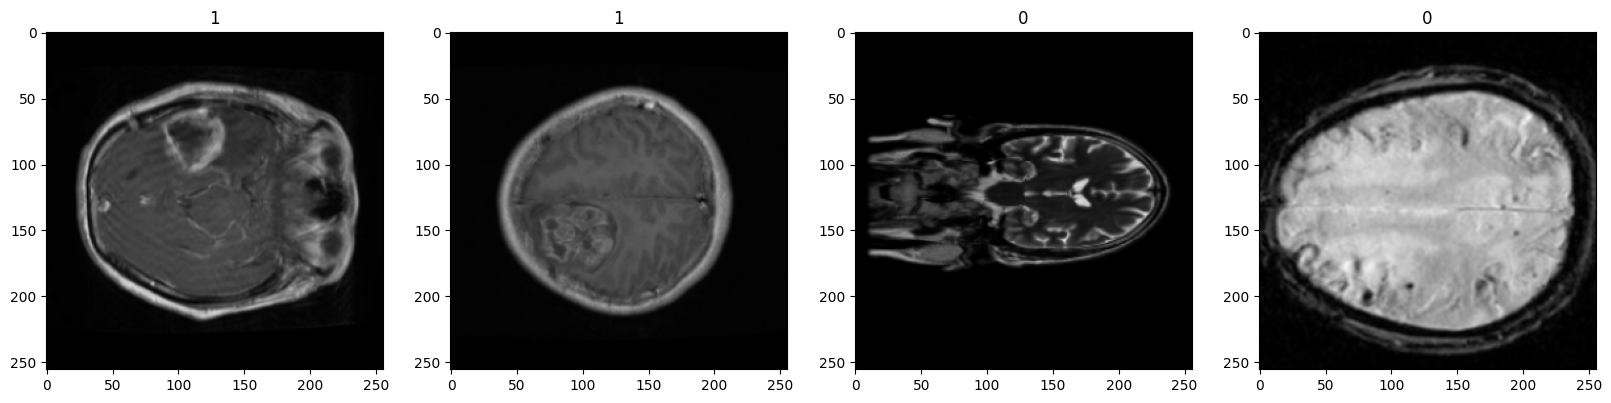

In [277]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([1,2,7,17]):
    ax[idx].imshow(batch_training[0][img_index])
    ax[idx].title.set_text(batch_training[1][img_index])

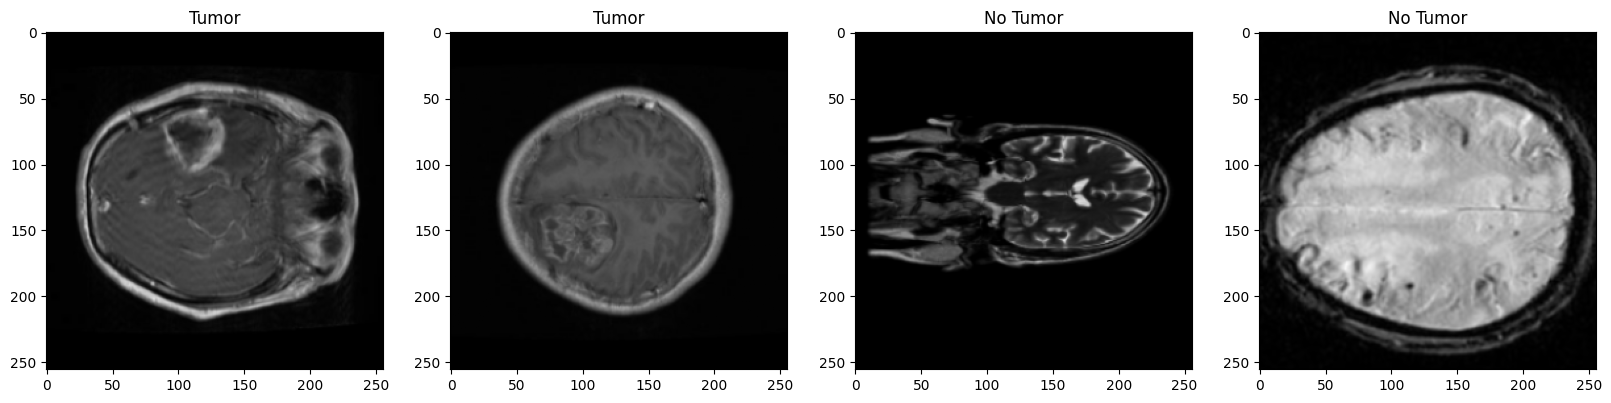

In [278]:
new_class_names = ['No Tumor', 'Tumor']
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([1,2,7,17]):
    ax[idx].imshow(batch_training[0][img_index])
    #ax[idx].title.set_text(batch_training[1][img_index])
    ax[idx].title.set_text(new_class_names[batch_training[1][img_index]])

## Deep Model


In [279]:
model = Sequential()

# First have an input layer, going to have 16 filters, filter is a 3x3, stride of 1
# Relu activation turns negative values to 0, and preserves positive values
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = IMAGE_SIZE))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # condense values

# Fully connected layers
model.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.002)))
# model.add(Dropout(rate=0.1))

model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.02)))
#model.add(Dropout(rate=0.1))


# Final layer that gives a single output and represets the label
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer= OPT, loss='binary_crossentropy', metrics=['accuracy'])

In [280]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 32)       

Training

In [281]:
logdir = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

early_stopping = EarlyStopping(monitor='val_loss', patience=4)


In [282]:
hist = model.fit(Training_data, epochs = 10, validation_data = Validation_data, callbacks = [tensorboard_callback, early_stopping])


Epoch 1/5
73/73 [==============================] - 491s 7s/step - loss: 1.6473 - accuracy: 0.8552 - val_loss: 0.9136 - val_accuracy: 0.8643
Epoch 2/5
73/73 [==============================] - 441s 6s/step - loss: 0.6300 - accuracy: 0.8776 - val_loss: 0.4171 - val_accuracy: 0.9124
Epoch 3/5
73/73 [==============================] - 432s 6s/step - loss: 0.3858 - accuracy: 0.9042 - val_loss: 0.3099 - val_accuracy: 0.9124
Epoch 4/5
73/73 [==============================] - 426s 6s/step - loss: 0.2828 - accuracy: 0.9253 - val_loss: 0.2582 - val_accuracy: 0.9107
Epoch 5/5
73/73 [==============================] - 414s 6s/step - loss: 0.2639 - accuracy: 0.9227 - val_loss: 0.2478 - val_accuracy: 0.9107


## Evaluation and Testing

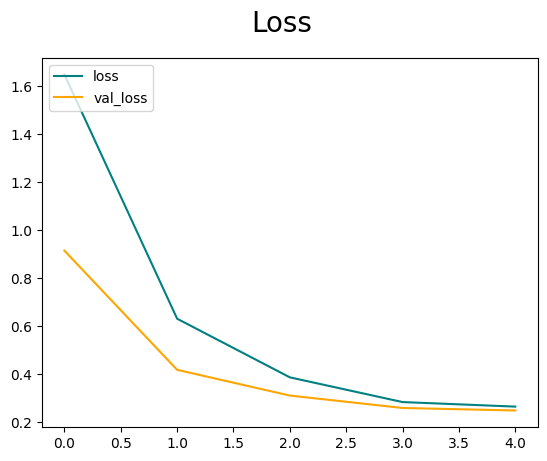

In [283]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

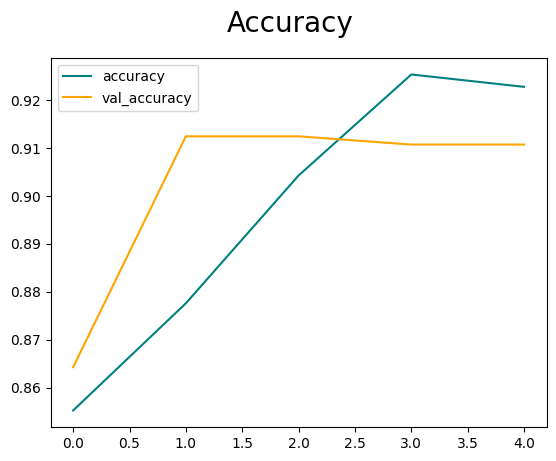

In [284]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [285]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [286]:
labels_testing = []
X_test =[]

for batch in Testing_data.as_numpy_iterator():
    x_test, y_test = batch
    labels_testing.extend(y_test)
    X_test.extend(x_test)

labels_testing = np.array(labels_testing)
X_test = np.array(X_test)



In [ ]:

y_ = labels_testing # Our true y values
yhat_ =[] # Empty list for predicted variables

yhat = model.predict(X_test)

yhat_binary = np.argmax(yhat, axis=1)

yhat_.append(yhat_binary)

pre.update_state(y_, yhat_binary)
re.update_state(y_, yhat_binary)
acc.update_state(y_, yhat_binary)

In [ ]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

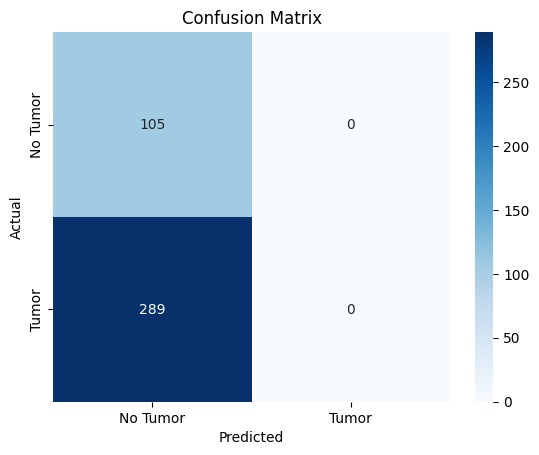

In [289]:
class_names = ["No Tumor", "Tumor"]

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_, yhat_binary)

sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()